# Objective of this Notebook
We will use an SVM classifier to predict if a credit card transaction is fraudulent or not.

We'll use a dataset from kaggle. You can download it at https://www.kaggle.com/mlg-ulb/creditcardfraud

The dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

## 1. Data Exploration
<a id='1-data-exploration'></a>

### Reading data
<a id='reading-data1'></a>

In [1]:
import pandas as pd
import os

dataset = pd.read_csv('creditcard.csv')
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Target classes repartition

Let's see the proportion of the non fraudulent and fraudulent classes.

In [2]:
print(dataset['Class'].value_counts(),'\n')

class0_total = dataset['Class'].value_counts()[0]
class1_total = dataset['Class'].value_counts()[1]
total =  class1_total + class0_total
print('Percentage of class 0:',(class0_total / total)*100, "%")
print('Percentage of class 1:',(class1_total / total)*100, "%")

0    284315
1       492
Name: Class, dtype: int64 

Percentage of class 0: 99.82725143693798 %
Percentage of class 1: 0.1727485630620034 %


Given that the class 0 is much more present than the class 1, we are in an imbalanced case. 
Thus, later, when we'll evaluate our model, we should use an appropriate metric of evaluation for skewed classes.
We could use **precision**, **recall** and finally compute the **F1 score**

### Correlation between features

In [3]:
correlations_with_Time = dataset.corr()['Time'].abs().sort_values(ascending=False)
correlations_with_Amount = dataset.corr()['Amount'].abs().sort_values(ascending=False)
correlations_with_Class = dataset.corr()['Class'].abs().sort_values(ascending=False)

print('5 best correlations with Time feature:\n',correlations_with_Time[1:6],'\n')
print('5 best correlations with Amount feature:\n',correlations_with_Amount[1:6],'\n')
print('5 best correlations with Class feature:\n',correlations_with_Class[1:6],'\n')

5 best correlations with Time feature:
 V3     0.419618
V11    0.247689
V25    0.233083
V15    0.183453
V5     0.173072
Name: Time, dtype: float64 

5 best correlations with Amount feature:
 V2     0.531409
V7     0.397311
V5     0.386356
V20    0.339403
V1     0.227709
Name: Amount, dtype: float64 

5 best correlations with Class feature:
 V17    0.326481
V14    0.302544
V12    0.260593
V10    0.216883
V16    0.196539
Name: Class, dtype: float64 



Some features seem correlated. 

If the features have some correlations between them, then I might prefer using multivariate normal distribution.

Why ? Because generally speaking, using the multivariate Gaussian distribution yields better results since
it captures correlations between features (if they exist). 

Before Applying data transformation, we can plot histograms for each feature from our resampled data.

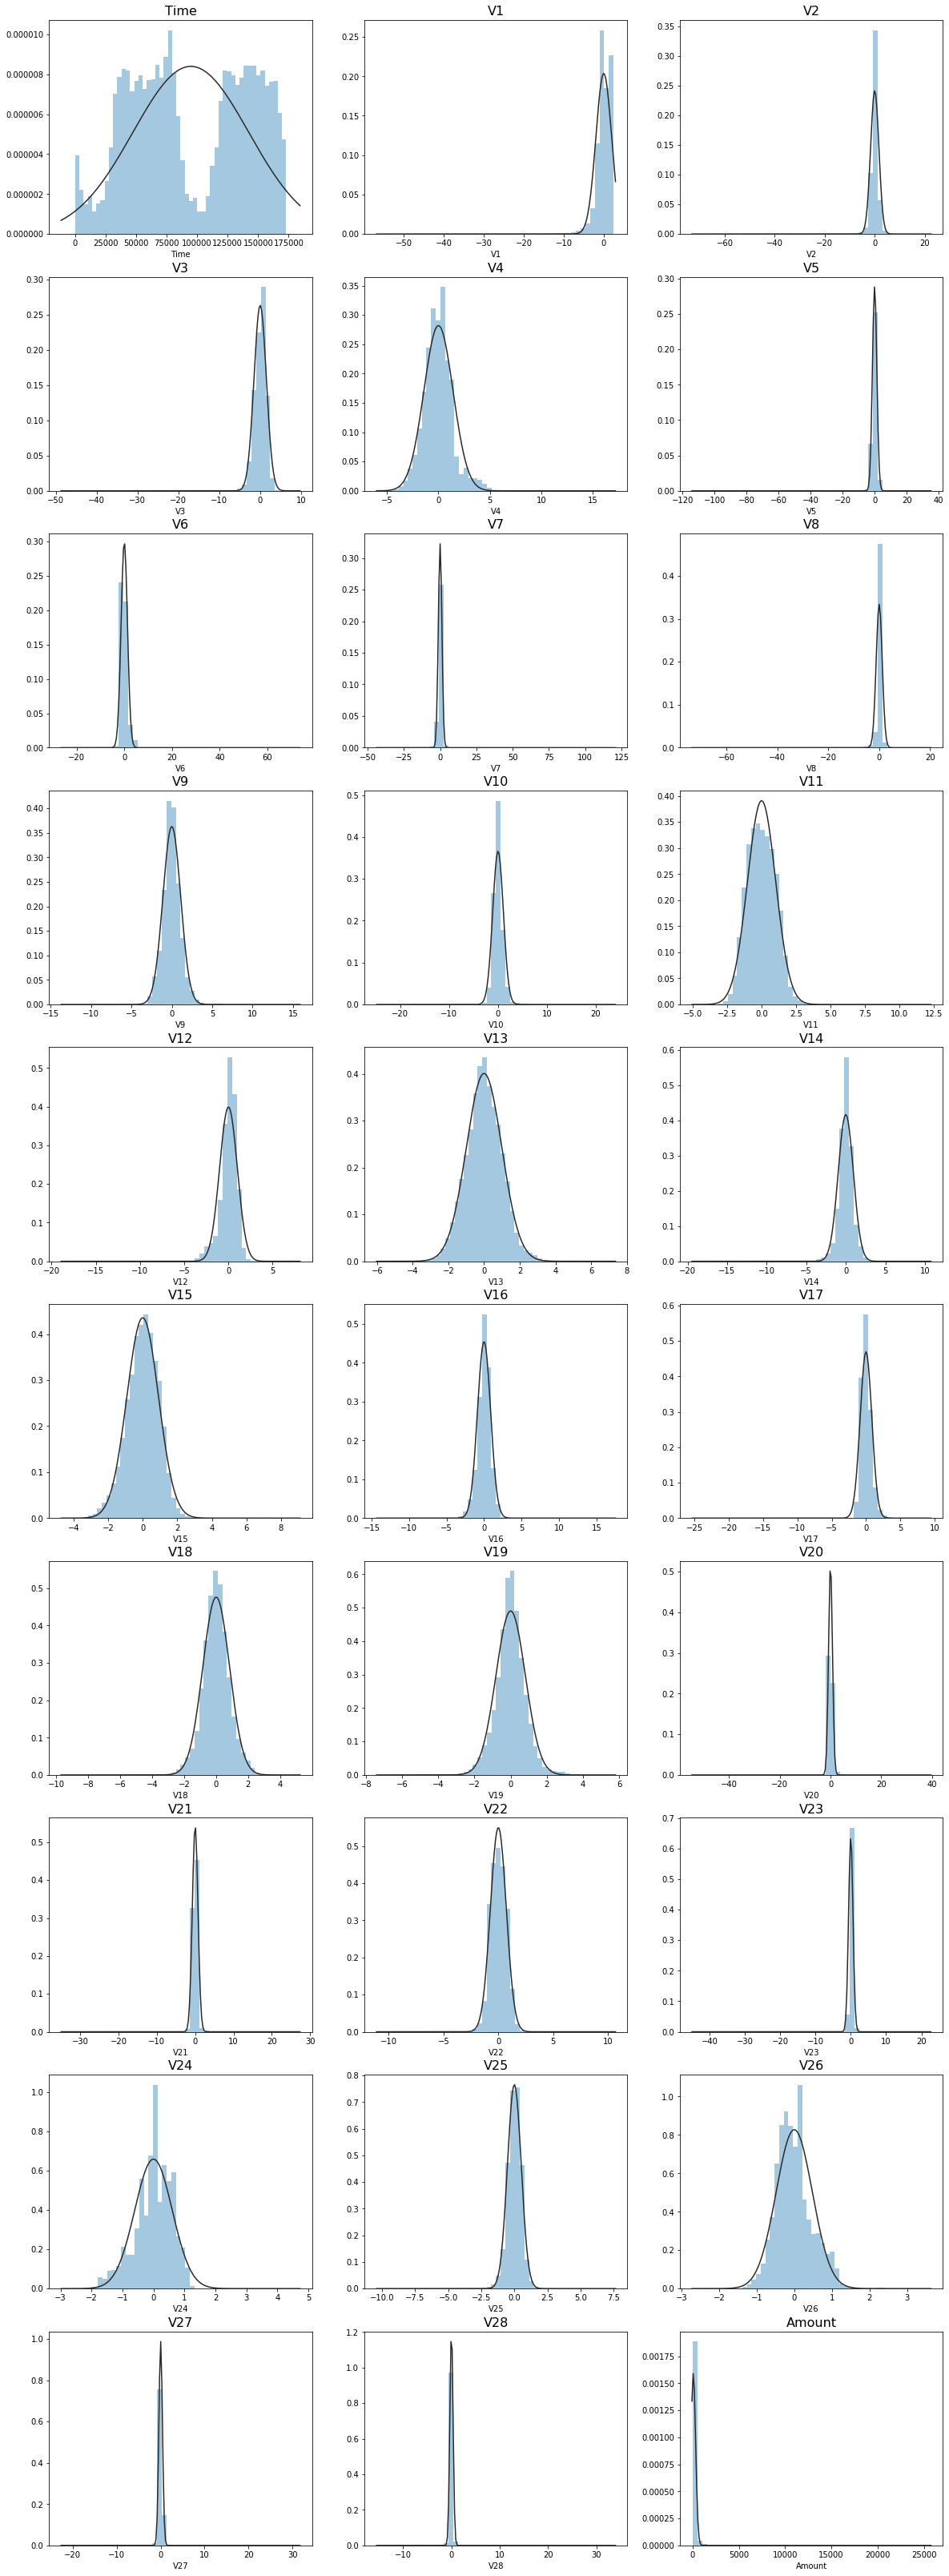

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns


def plotFeatureDistributions(dataset):
    fig, axes = plt.subplots(len(dataset.columns)//3, 3, figsize=(20, 58))
    i=0
    for triaxis in axes:
        for axis in triaxis:
            column = dataset.columns[i]
            # Fit a normal distribution to the data:
            mu, std = norm.fit(dataset[column])
            # Plot the histogram.
            p = sns.distplot(dataset[column],fit=norm, kde=False,ax=axis).set_title(column, fontsize=16)
            i+=1
            
plotFeatureDistributions(dataset)

We can see that many features don't follow a normal distribution, thats why we will apply data transformation to make our features 'look more normal' for our future algorithm.

### Data Transformation
To check visually, if our data looks normal we can use Histograms like we did before and also Quantile-Quantile plots.
There are also, a range of techniques that we can use to check if our data sample deviates from a Gaussian distribution, called normality tests.

In this section, we will try several transformations for our feature and use a normality test to choose the best transformation. The latter will be the transformation giving the highest p-value on the normality test. The higher the p-value, the more normal is our feature distribution.

We will also look at the skewness for each feature, if the feature is right skewed we will apply right skewed transformation to make the distribution more normal. However if the feature is left skewed, we should reflect the feature distribution (with the function reflectData) to make it right skewed and as before apply right skewed transformations.

Features which are already following a normal distribution, i.e. which are satisfying the condition p-value > 0.05 on the normality test are not transformed since they already follow the desired normal distribution.

In [5]:
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as stats
import numpy as np


def getTransformations(data):
    transformations = {}
    transformations['none'] = data
    transformations['log'] = np.log(data)
    transformations['sqrt'] = np.sqrt(data)
    transformations['cuberoot'] = np.power(data,1/3)
    transformations['boxcox'], _ = stats.boxcox(data)
    
    # reshape data to have rows and columns
    data = data.reshape((len(data),1))
    quantile = QuantileTransformer(output_distribution='normal')    
    # reshape data to have a  1 x len(data) vector
    transformations['quantile'] = quantile.fit_transform(data).reshape((1,len(data)))[0]
    return transformations
        

def getMoreNormalData(transformations):
    transformation_names = list(transformations.keys())
    best_transformation = transformation_names[0]
    stat, best_pvalue = stats.normaltest(transformations[best_transformation])
    transformation_result = transformations[best_transformation]
    
    for i in range(1,len(transformation_names)):
        current_transformation = transformation_names[i]
        current_stat, current_pvalue = stats.normaltest(transformations[current_transformation])
        if (current_pvalue > best_pvalue):
            best_pvalue = current_pvalue
            best_transformation = current_transformation
            transformation_result = transformations[best_transformation]
    
    return best_transformation, transformation_result, best_pvalue
    
    
def reflectData(data):
    return max(data)+1-data


def isNormal(feature_data,alpha=0.05):
    stat,pvalue=stats.normaltest(feature_data)
    #if pvalue > alpha there is no significant difference between the normal distribution and the feature distribution
    return pvalue > alpha


#Finds the best transformation for each feature distribution
def findBestTransformations(data):
    features = data.columns
    for feature_name in features:
        feature_values = data[feature_name].values
        if (isNormal(feature_values)): pass   
        else:
            feature_skewness =data[feature_name].skew()
            
            #convert left skewed to right skewed data
            if (feature_skewness < 0):
                feature_values = reflectData(feature_values)
            
            #apply transformations to a right skewed distribution 
            transformations = getTransformations(feature_values)
            best_transformation, transformation_result, best_pvalue = getMoreNormalData(transformations)
            data[feature_name] = transformation_result
            print(feature_name, "'s best transformation is ",best_transformation, ' with p-value:',best_pvalue)
    return data


# Change the minimum values to make them greater than 0 to successfully apply data transformation
def changeFeaturesMinValues(data):
    for column_name in data.columns:
        feature_values = data[column_name]
        if (min(feature_values) < 0):
            min_abs_value = abs(min(feature_values))
            feature_values = feature_values + min_abs_value
        
        feature_values = feature_values + 0.15
        data[column_name] = feature_values    
    return data
 
    
def transformData(data):
    features = data.drop(columns=['Class'])
    features = changeFeaturesMinValues(features)
    data[features.columns] = findBestTransformations(features)
    return data

transformed_dataset = transformData(dataset)

Time 's best transformation is  quantile  with p-value: 0.014137011653902814
V1 's best transformation is  quantile  with p-value: 0.0023078648027034907
V2 's best transformation is  quantile  with p-value: 1.8489847405537395e-08
V3 's best transformation is  quantile  with p-value: 3.457847513705093e-07
V4 's best transformation is  quantile  with p-value: 0.0006284791155903207
V5 's best transformation is  quantile  with p-value: 7.676745627486344e-07
V6 's best transformation is  quantile  with p-value: 9.724925130952395e-05
V7 's best transformation is  quantile  with p-value: 1.6049893714478628e-07
V8 's best transformation is  quantile  with p-value: 0.001358387945846951
V9 's best transformation is  quantile  with p-value: 0.7527043688857543
V10 's best transformation is  quantile  with p-value: 6.02273098685924e-11
V11 's best transformation is  quantile  with p-value: 4.3820729693019474e-07
V12 's best transformation is  quantile  with p-value: 0.004493420204150793
V13 's best

Most of the features are, now, following a normal distribution because their p-value are greater than 0.05.
We can plot their histogram and fit a normal distribution to each of them.

## Histograms and Normal Distributions
Let's plot for each feature, their histogram and their fitted normal distrubtion.

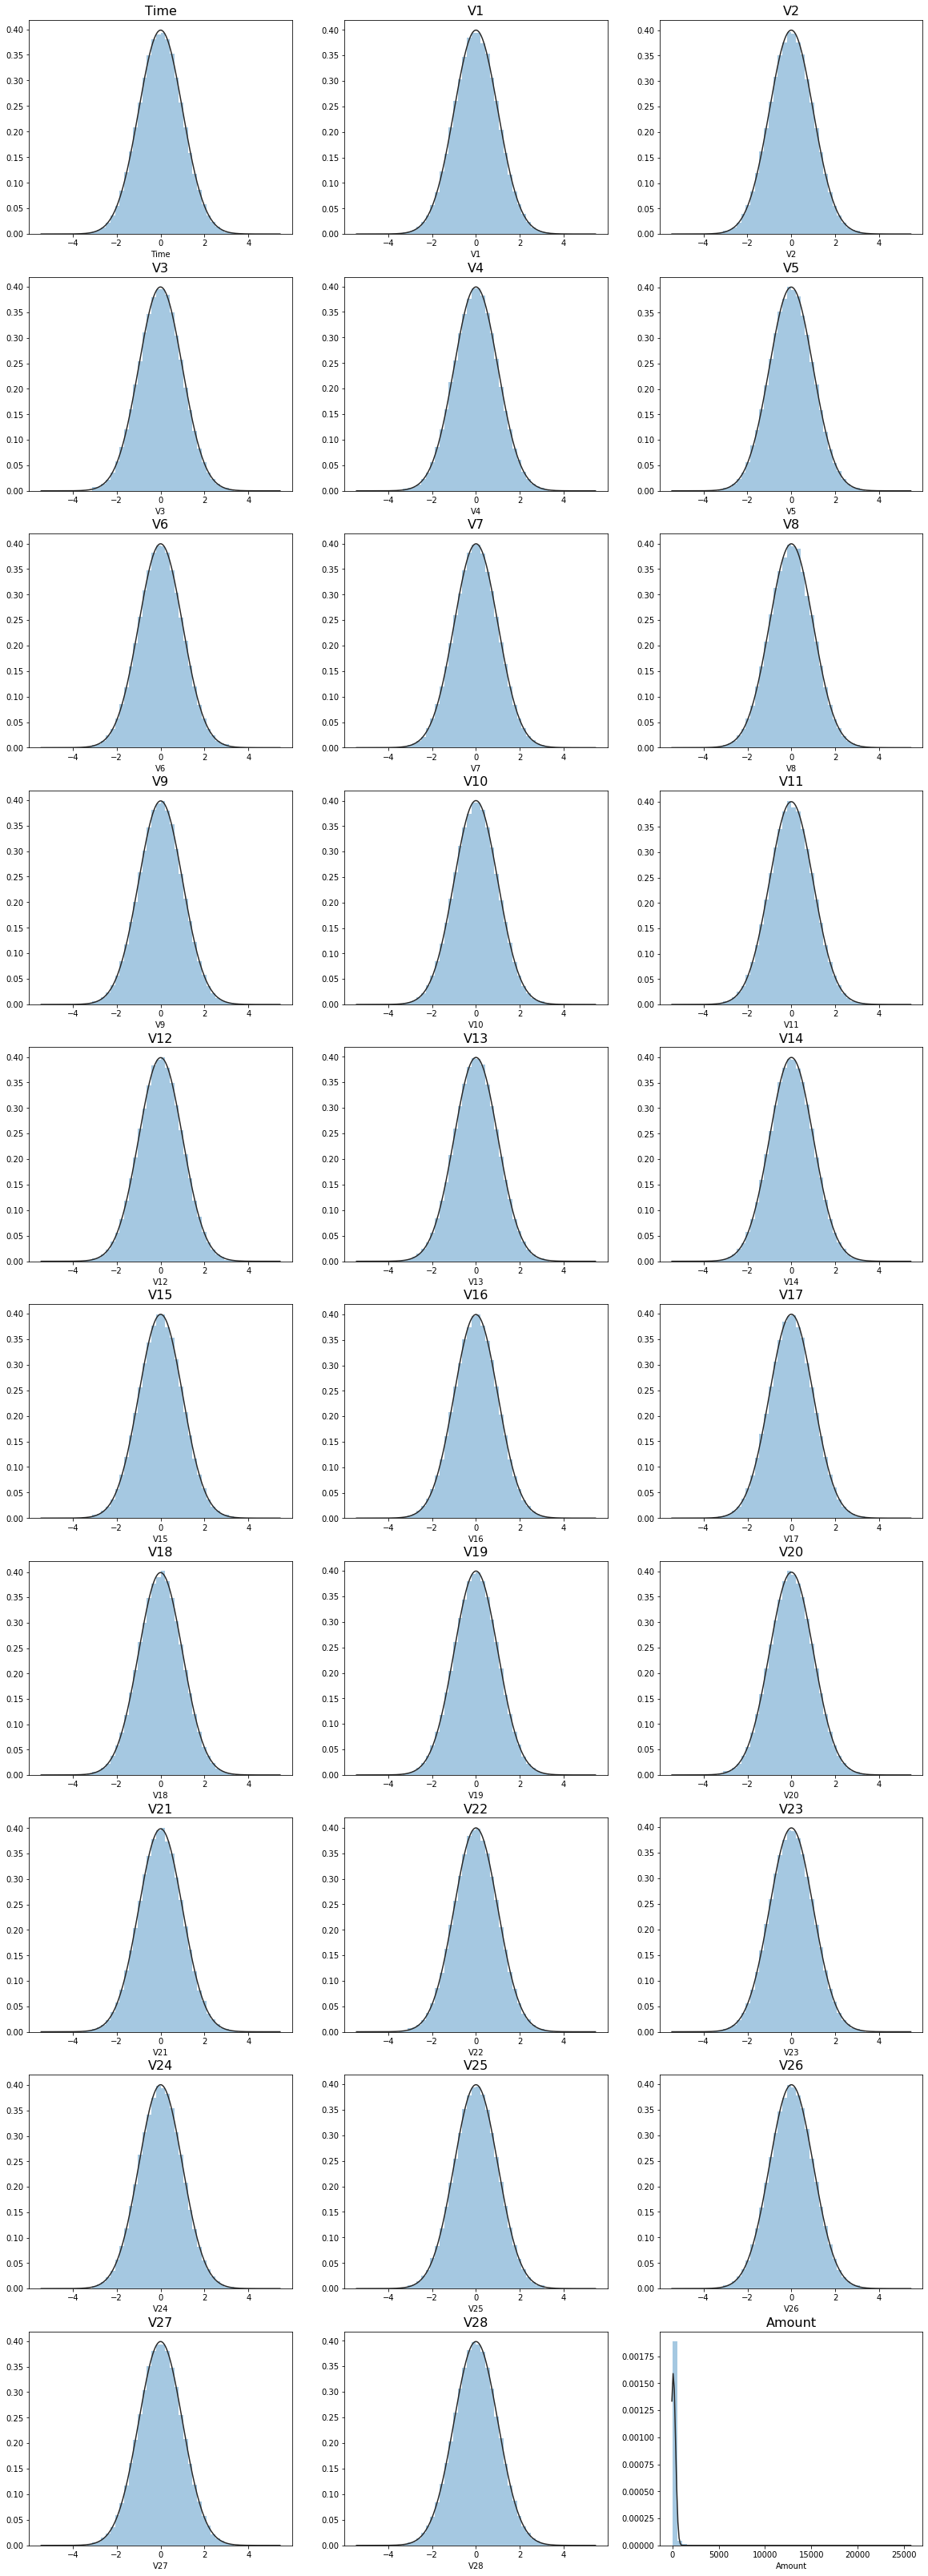

In [6]:
plotFeatureDistributions(transformed_dataset)

## 2. Data preprocessing
<a id='2-data-preprocessing2'></a>
### Feature scaling
<a id='feature-scaling1'></a>

Before applying our algorithm to our data, it is important to perform scaling of that data. Main purpose of scaling data before
processing is to avoid attributes in greater numeric ranges. Other purpose is to avoid some types of numerical difficulties
during calculation.  Large attribute values might cause numerical problems.

Two techniques we can use: 

* Feature scaling involves dividing the input values by the range (i.e. the maximum value minus the minimum value) of the input variable, resulting in a new range of just 1. 

* Mean normalization involves subtracting the average value for an input variable from the values for that input variable resulting in a new average value for the input variable of just zero. 

-> To implement both of these techniques, we can adjust our input values as shown in this formula:
$Z = \frac{x - \mu}{\sigma}$ where x is the feature value, $\mu$ is the average of all the values for the feature concerned and $\sigma$ is the standard deviation (or the range value : max-min)

In [7]:
from sklearn.preprocessing import StandardScaler

def scaleData(dataset):
    scaler = StandardScaler()

    #Features column names without the target 'target' 
    features_columns_names = dataset.columns[:-1]
    scaled_data = scaler.fit_transform(dataset[features_columns_names])

    #Replacing features old values with their scaled values
    dataset.loc[:, features_columns_names] = scaled_data
    return dataset

scaled_dataset = scaleData(transformed_dataset)

## Modeling part

### Creation of training / validation / test sets
<a id='creation-of-training---validation---test-sets'></a>
We will create 3 datasets : 
* training set (60% of all the dataset) with only non fraudulent examples
* validation set (20%) with non fraudulent examples and the first half of the fraudulent examples
* test set (20%) with the remaining non fraudulent instances and the second half of the fraudulent examples

In [8]:
from sklearn.model_selection import train_test_split 

#To retrieve in a dataframe a certain amount of data size, with target class 'classtype' (0 : non fraudulent , 1 : fraudulent)
def getData(dataframe,size,classtype):
    indexes = []
    df_indexes = dataframe.index
    instances_size = dataframe.shape[0]
    counter=0
    for i in range(instances_size):
        instance = dataframe.iloc[i,:]
        if (instance.Class == classtype): 
            indexes.append(df_indexes[i])
            counter+=1
            if (counter==size):break
    
    return indexes



def getTrainingSet(dataset,total_instances_size):
    #Training set composed of 60% of the total number of instances
    training_instances_size = round(0.60 * total_instances_size)
    trainingset_indexes = getData(dataset,training_instances_size,0)
    training_set = dataset.loc[ trainingset_indexes , :]
    y_train = training_set['Class']
    X_train = training_set.drop(columns=['Class'])
    
    newdataset = dataset.drop(trainingset_indexes)
    print('Training set target class repartition:\n',y_train.value_counts(),'\n')
    return X_train, y_train, newdataset



def getValidationSet(new_dataset, total_instances_size):

    #Validation set composed of 20% of the total number of instances
    validation_instances_size = round(0.20 * total_instances_size)
    total_fraudulent_instances_size = len(new_dataset[new_dataset.Class == 1])
   
    #The validation and test sets will have half of the total number of fraudulent instances
    fraudulent_size = round(total_fraudulent_instances_size/2)
    
    #Validation set composed of half of the fraudulent instances + the non fraudulent instances
    valset_fraud_indexes = getData(new_dataset,fraudulent_size,1) 
    valset_nonfraud_indexes = getData(new_dataset,validation_instances_size-fraudulent_size,0)
    val_indexes = valset_fraud_indexes + valset_nonfraud_indexes
    validation_set = new_dataset.loc[ val_indexes , :]
    y_validation = validation_set['Class']
    X_validation = validation_set.drop(columns=['Class'])
    print('Validation set target class repartition:\n',y_validation.value_counts(),'\n')
    
    test_set = new_dataset.drop(val_indexes)
    return X_validation,y_validation, test_set
    
    
    
def getTestSet(test_set,total_instances_size):
    #Test set composed of 20% of the total number of instances
    test_instances_size = round(0.20 * total_instances_size)
    y_test = test_set['Class']
    X_test = test_set.drop(columns=['Class'])
    
    print('Test set target class repartition:\n',y_test.value_counts(),'\n')
    return X_test, y_test
 
def splitDataset(dataset):
    total_instances_size = dataset.shape[0]
    X_train, y_train, newdataset = getTrainingSet(dataset,total_instances_size)
    X_validation, y_validation, test_set = getValidationSet(newdataset,total_instances_size)
    X_test, y_test = getTestSet(test_set,total_instances_size)
    return X_train, y_train, X_validation, y_validation, X_test, y_test


X_train, y_train, X_validation, y_validation, X_test, y_test = splitDataset(scaled_dataset)

Training set target class repartition:
 0    170884
Name: Class, dtype: int64 

Validation set target class repartition:
 0    56715
1      246
Name: Class, dtype: int64 

Test set target class repartition:
 0    56716
1      246
Name: Class, dtype: int64 



### Algorithm steps
1) we compute the mean for each feature j in the training set:
$$\mu_j = \frac{1}{m} \sum_{i=1}^{m}x_j^{(i)}$$

2) we compute the variance for each feature j in the training set:
$$\sigma^2_j = \frac{1}{m} \sum_{i=1}^{m}(x_j^{(i)}-\mu_j)^2$$


3) Univariate vs Multivariate Gaussian Distribution
#### Univariate Gaussian
If the features of the observations are independently distributed, then we can use the
single variate normal distribution.
* We use the mean and variance to compute a probability (of being fraudulent) for each feature j:
$$p(x_j;\mu_j,\sigma^2_j) = \frac{1}{\sqrt{2 \pi \sigma^2_j}} exp^{-\frac{(x_j - \mu_j)^2}{2 \sigma^2_j}}$$

* The final probability for an instance x is the product of all the probabilities coming from each feature j :
$$ p(x)=\prod_{j=1}^{n} p(x;\mu_j,\sigma^2_j)$$

#### Multivariate Gaussian
The multivariate gaussian distribution is an extension of anomaly detection and may (or may not) catch more anomalies.

Instead of modeling the product of all probabilities for each feature to compute the final probability p(x) for an instance x,  we will model p(x) all in one go:
$$p(x;\mu,\Sigma) = \frac{1}{(2 \pi)^{(n/2)} |\Sigma|^{(1/2)}} exp^{ -\frac{1}{2} (x - \mu)^T \Sigma^{-1}(x - \mu)}$$

Σ is the covariance matrix.
Varying Σ changes the shape, width, and orientation of the contours. Changing μ will move the center of the distribution.

#### Choosing between both models
Generally speaking, using the multivariate Gaussian distribution yields better results since
it captures correlations (if they exist). However, the original model maintains some advantages: it is computationally cheaper (no matrix to invert, which is costly for large number of features) and it performs well even with small training set size (in multivariate Gaussian model, it should be greater than the number of features for Σ to be invertible).
Using uni-variate normal distribution when there are correlations in the data might yield
more false negatives (flagging fraudulent transactions as normal).

Sometimes a fraudulent transaction might be seen by this model as a normal transaction because each feature falls within its normal distribution with its mean and variance. Thus, using uni-variate normal distribution will sometimes pass fraudulent examples as normal. Where in reality, the transaction is anomalous because of the combination of the features is not normal.

However, the downside of the multivariate normal distribution lies in inverting Σ. It is computationally expensive when the number of features becomes large. Σ becomes non-invertible when n > m (with n the number of features and m the number of examples)

Since our features are correlated, and n<m, we'll use the Multivariate Gaussian distribution formula to compute for an example x, the probability of being fraudulent.

4) Evaluation of the model with the F1 score, precision and recall

In [9]:
import math
from sklearn.metrics import f1_score

#Estimate the mean and the variance for a dataset/drataframe
def estimateGaussianParameters(dataframe):
    features = dataframe.columns
    m = dataframe.shape[0]
    n = dataframe.shape[1]
    means = []
    variances = []
    for feature in features:
        feature_values = dataframe[feature].values
        mu = np.sum(feature_values) / m
        sigma2 = (np.sum((feature_values - mu)**2)) / m
        means.append(mu)
        variances.append(sigma2)
    means = np.asarray(means).reshape(1,n)
    variances = np.asarray(variances).reshape(1,n)
    return means,variances



def multivariateGaussian(X, mu, sigma2):
    n = np.size(sigma2, 1)
    m = np.size(sigma2, 0)
    
    if n == 1 or m == 1: sigma2 = np.diag(sigma2[0, :])
    X = X - mu
    pi = math.pi
    det = np.linalg.det(sigma2)
    inv = np.linalg.inv(sigma2)
    val = (-0.5)*np.sum(np.multiply((X@inv),X), 1)
    p = np.power(2*pi, -n/2)*np.power(det, -0.5)*np.exp(val)
    return p

def getTrainingProbabilitiesAndParams(X_train):
    means, variances = estimateGaussianParameters(X_train)
    training_probabilities = multivariateGaussian(X_train,means,variances)
    return training_probabilities, means, variances

training_probabilities, means, variances = getTrainingProbabilitiesAndParams(X_train)

### Selection of the best epsilon threshold
Xtrain_proba contains the probabilities of being fraudulent, for each instance in the training set.
Now, we will use the validation set to find the best epsilon threshold which will separate fraudulent instances from non fraudulent instances.
We will use the training probabilities to produce several values of threshold.

The algorithm works as follows:
1. Let epsilon be the smallest probability in the training set.
2. Flag all probabilities in the CV set below epsilon as fraudulent.
3. Calculate F1-score.
4. Increase epsilon by a small step-size.
5. Repeat steps 2 - 5. Stop when epsilon > the largest probability in the training set.

The epsilon that yields the highest F1-score is then used for the test set.

In [10]:

#Get all the cutoff epsilons thresholds to flag an example as anomalous or not
def getEpsilons(training_probabilities):
    minp = min(training_probabilities)
    maxp =  max(training_probabilities)
    return np.linspace(minp,maxp,1000)



#Gives the best threshold maximizing the F1 score
def getBestThreshold(y_validation, validation_probabilities, epsilons):
    bestF1 = 0
    bestEpsilon = 0
    number_of_epsilons = len(epsilons)
    for eps_idx in range(number_of_epsilons):
        epsilon = epsilons[eps_idx]
        predictions = (validation_probabilities < epsilon)
        predictions = predictions.values
        try:
            F1, precision, recall, tp, fp, tn, fn = evaluateModel(y_validation,predictions)
            if (F1 > bestF1):
                bestF1 = F1
                bestEpsilon = epsilon
                
        except ZeroDivisionError:
            pass
            #print('Warning dividing by zero!!')   
        
    return bestEpsilon, bestF1


#Evaluate predictions on a imbalanced dataset 
def evaluateModel(y_validation, predictions):
    precision, recall = 0,0
    true_positives,false_positives,true_negatives, false_negatives = 0,0,0,0
    for i in range(len(predictions)):
        if (predictions[i] == y_validation[i] == 1):
            true_positives+=1
        elif (predictions[i] == 1 and y_validation[i] == 0):
            false_positives+=1
        elif (predictions[i] == 0 and y_validation[i] == 1):
            false_negatives+=1
        else:
            true_negatives +=1
    
    precision = true_positives/(true_positives + false_positives)
    recall = true_positives/(true_positives + false_negatives)
    F1 = 2*precision*recall/(precision + recall) 
    return F1, precision, recall, true_positives,false_positives, true_negatives,false_negatives

def findBestThreshold(X_validation, training_probabilities=training_probabilities, means=means, variances=variances):
    epsilons = getEpsilons(training_probabilities)
    validation_probabilities = multivariateGaussian(X_validation,means,variances)
    best_epsilon, best_f1 = getBestThreshold(y_validation.values, validation_probabilities, epsilons)
    print('Best F1:',best_f1,' obtained with the best epsilon:',best_epsilon)
    return best_epsilon, best_f1
    
best_epsilon, best_f1 = findBestThreshold(X_validation) 

Best F1: 0.008718491226790208  obtained with the best epsilon: 1.887969144580271e-16


The best epsilon threshold is the one which gives the highest F1 score. 

Now that we know which epsilon is the best, we can use it on the test set.

### Testing the gaussian model with the best epsilon threshold

In [11]:

def getTestSetPredictions(X_test,best_epsilon,means=means,variances=variances):
    testset_probabilities = multivariateGaussian(X_test,means,variances)
    testset_predictions = np.where(testset_probabilities < best_epsilon, 1, 0)
    return testset_predictions



def printEvaluationResults(F1, precision, recall, tp, fp, tn, fn):
    print('Test F1 score:',F1,', Precision:',precision,', Recall:',recall)
    print('True Positives:',tp,' | False Positives:',fp, ' | True Negatives:',tn,' | False Negatives:',fn)

testset_predictions = getTestSetPredictions(X_test,best_epsilon)

#Evaluation part
F1_test, precision_test, recall_test, tp, fp, tn, fn = evaluateModel(y_test.values, testset_predictions)
printEvaluationResults(F1_test, precision_test, recall_test, tp, fp, tn, fn)


Test F1 score: 0.00863248763027687 , Precision: 0.0043349545358426726 , Recall: 1.0
True Positives: 246  | False Positives: 56502  | True Negatives: 214  | False Negatives: 0


As we can see with the F1 score, our model performs poorly. The high recall tells us that we found most of the fraudulent cases (True Positives value high). However a low value of Precision tells us that our model is also flagging a lot of non fraudulent transactions as fraudulent (False Positives value high).

Let's try to improve our F1 score by using sampling techniques like Downsampling/UpSampling.

### Upsampling and Downsampling

#### 1. Upsampling the minority class
Up-sampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal.

There are several heuristics for doing so, but the most common way is to simply resample with replacement.

#### 2. Downsampling the majority class
Down-sampling involves randomly removing observations from the majority class to prevent its signal from dominating the learning algorithm.

The most common heuristic for doing so is resampling without replacement.
I will perform downsampling, here are the steps:
* First, we'll separate observations from each class into different DataFrames.
* Next, we'll resample the majority class without replacement, setting the number of samples to be much lower than the previous number of samples.
* Finally, we'll combine the down-sampled majority class DataFrame with the original minority class DataFrame.

After downsampling, we will apply as before the following steps : 
1. Transform our features to obtain more normally distributed features
2. Apply Feature scaling
3. Split the dataset into training/validation/test sets
4. Compute probabilities for the training set
5. Find the best threshold using the validation set and the training set.
6. Test and evaluate our hypothesis on the test set


In [12]:
from sklearn.utils import resample

def upSample(dataset, rate=0.03):
    # Separate majority and minority classes
    df_majority = dataset[dataset.Class==0]
    df_minority = dataset[dataset.Class==1]
 
    instances_size = df_minority.shape[0]
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=round(instances_size + (instances_size*rate)),  
                                 random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    dataset = pd.concat([df_majority, df_minority_upsampled])
    
    # Display new class counts
    print('Up sampling target class result:\n',dataset.Class.value_counts(),'\n')
    return dataset


def downSample(dataset,rate=0.02):
    # Separate majority and minority classes
    df_majority = dataset[dataset.Class==0]
    df_minority = dataset[dataset.Class==1]

    instances_size = df_majority.shape[0]
    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=round(instances_size*rate),   
                                     random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    dataset = pd.concat([df_majority_downsampled, df_minority])
    
    print('Down sampling target class result:\n',dataset.Class.value_counts(),'\n')
    
    return dataset


#dataset = upSample(dataset)
sampled_dataset = downSample(dataset)


Down sampling target class result:
 0    5686
1     492
Name: Class, dtype: int64 



In [13]:
#Step 1:Transform our features to obtain more normally distributed features
transformed_dataset = transformData(sampled_dataset)


#Step 2:Apply Feature scaling
scaled_dataset = scaleData(transformed_dataset)



Time 's best transformation is  quantile  with p-value: 0.128399017328586
V1 's best transformation is  boxcox  with p-value: 0.22357849030086918
V2 's best transformation is  boxcox  with p-value: 0.01377926495547228
V3 's best transformation is  quantile  with p-value: 0.09465037703710114
V4 's best transformation is  quantile  with p-value: 0.12525060497177667
V5 's best transformation is  quantile  with p-value: 0.18052762847142698
V6 's best transformation is  boxcox  with p-value: 0.2909203526055242
V7 's best transformation is  quantile  with p-value: 0.17412409803746695
V8 's best transformation is  boxcox  with p-value: 6.557299707112053e-08
V9 's best transformation is  sqrt  with p-value: 3.0237997253211257e-09
V10 's best transformation is  boxcox  with p-value: 0.006060530274406326
V11 's best transformation is  quantile  with p-value: 0.10916102131753967
V12 's best transformation is  boxcox  with p-value: 3.948306001247785e-12
V14 's best transformation is  quantile  wit

In [14]:
#Step 3:Split the dataset into training/validation/test sets
X_train, y_train, X_validation, y_validation, X_test, y_test = splitDataset(scaled_dataset)


#Step 4:Compute probabilities for the training set
training_probabilities, means, variances = getTrainingProbabilitiesAndParams(X_train)

Training set target class repartition:
 0    3707
Name: Class, dtype: int64 

Validation set target class repartition:
 0    990
1    246
Name: Class, dtype: int64 

Test set target class repartition:
 0    989
1    246
Name: Class, dtype: int64 



In [15]:
#Step 5:Find the best threshold using the validation set and the training set.
best_epsilon, best_f1 = findBestThreshold(X_validation) 


#Step 6:Test and evaluate our hypothesis on the test set
testset_predictions = getTestSetPredictions(X_test,best_epsilon)
F1_test, precision_test, recall_test, tp, fp, tn, fn = evaluateModel(y_test.values, testset_predictions)
printEvaluationResults(F1_test, precision_test, recall_test, tp, fp, tn, fn)

Best F1: 0.38948233360723084  obtained with the best epsilon: 1.887969144580271e-16
Test F1 score: 0.39228295819935693 , Precision: 0.24448897795591182 , Recall: 0.991869918699187
True Positives: 244  | False Positives: 754  | True Negatives: 235  | False Negatives: 2


As we can see, using downsampling (or upsampling) here, improved the precision and thus the F1 score.

Other alternatives could be to :
* downsample the majority class to obtain the same amount of examples as the minority class.
* upsample the minority class to obtain the same amount of examples as the majority class.
* use both: upsample the minority class with the same rate as the majority class

So far, we've looked at two ways of addressing imbalanced classes by resampling the dataset
Using Downsampling and Upsampling to create a more balanced dataset could make us change the evaluation metric. 

We could switch from the F1 score metric to the Area Under ROC Curve (AUROC).

Intuitively, AUROC represents the likelihood of our model distinguishing observations from two classes.
In other words, if you randomly select one observation from each class, what's the probability that your model will be able to "rank" them correctly?

An other alternative coulb be to use tree-based algorithms. Decision trees often perform well on imbalanced datasets because their hierarchical structure allows them to learn signals from both classes.

In modern applied machine learning, tree ensembles (Random Forests, Gradient Boosted Trees, etc.) almost always outperform singular decision trees.